In [2]:
%matplotlib inline

In [3]:
from matplotlib.pylab import *

In [4]:
# repo = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master"
# style.use("results/style_sheet.mplstyle")

# rc('figure', figsize=(8, 4))
# rc('savefig', bbox='tight')
# plt.rcParams.update({'font.size': 16})

import numpy as np
import torch
import torch.nn as nn
from models import resnet18_narrow as resnet18
from utils import get_loader
from utils.train_utils import AverageMeter, accuracy
import argparse
from sklearn.model_selection import ParameterGrid
import pickle
from tqdm import tqdm 
import copy
import glob
import numpy as np
import scipy
import copy

In [5]:
param_grid = {'mo': [0.0, 0.5, 0.9],  # momentum
              'width': [4, 6, 8],  # network width
              'wd': [0.0, 1e-4, 5e-4],  # weight decay
              'lr': [0.01, 0.0075, 0.005],  # learning rate
              'bs': [32, 128, 512],  # batch size
              'skip': [False, True], # skip
              'batchnorm': [False, True]  # batchnorm
}

checkpoints/cifar10/resnet/895_0_0.5_6_0.0001_0.0075_512_False_False/run_ms_0/measures.pkl
checkpoints/cifar10/resnet/533_0_0.9_8_0.0_0.01_32_False_False/run_ms_0/measures.pkl
checkpoints/cifar10/resnet/585_0_0.9_4_0.0_0.0075_32_False_False/run_ms_0/measures.pkl
checkpoints/cifar10/resnet/585_0_0.9_4_0.0_0.0075_32_False_False/run_ms_0/measures.pkl


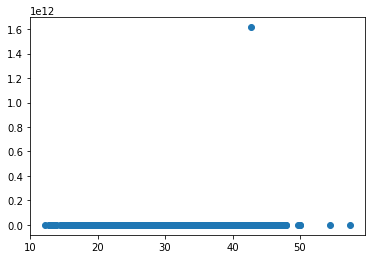

In [28]:
# plotting needs
labels = ["$\epsilon$ sharpness", "Pac Bayes", "$||H||_{F}$", "Fisher norm", "local_entropy_grad_norm", "Classical Entropy", "Trace", "Low pass filter", "local_entropy"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# ["eps_flat", "pac_bayes", "fro_norm", "fim", "local_entropy_grad_norm", "shannon_entropy", "eig_trace", "low_pass", "local_entropy"]

for meas in ["local_entropy_grad_norm"]:
    plotting_needs = [[], []]
    
    for fol in glob.glob("checkpoints/cifar10/resnet/*"):        
        try:
            with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                measures = pickle.load(f)
        except:
            print(f"{fol}/run_ms_0/measures.pkl")
            continue
            
        # discard model with less cross-entropy               
        if measures["train_loss"] > 0.01:
            continue

        # record flatness and gen_gap for it
        try:
            plotting_needs[1] += [measures[meas]]
            plotting_needs[0] += [-measures["val_acc"] + measures["train_acc"]]
        except:
            print(f"{fol}/run_ms_0/measures.pkl")
            continue
    
    fig, ax = plt.subplots()
    ax.scatter(plotting_needs[0], plotting_needs[1])
#     ax.set_ylim([0,0.06])

In [ ]:
# same results as fantastic papers
print("Measure")
for x in param_grid.keys():
    print(x, end=', ')
print(' ')
# labels = ["$\epsilon$ sharpness", "Pac Bayes", "$||H||_{F}$", "Fisher norm", "Local entropy", "Classical Entropy", "Trace", "Low pass filter"]
labels = ["local_entropy_grad_norm"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
idx = 0
# pick a measure
for meas in ["local_entropy_grad_norm"]:
    print(f"{labels[idx]} & ", end='')

    # pick a hyper-parameter
    for key, value in param_grid.items():
        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        # loop over all other set of hyper-parameters
        for params in grid:
            flat_measure = []
            gen_gap = []
            # and just vary a single hyper-parameter that we picked
            for v in value:
                params[key] = v
                # cifar
                name = f"checkpoints/cifar10/resnet/" \
                       f"*_0_{params['mo']}_{params['width']}_{params['wd']}_" \
                       f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"
                
                fol = glob.glob(name)[0]
                    
                try:
                    with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                        measures = pickle.load(f)
                except:
                    continue
                # discard model with less cross-entropy               
                if measures["train_loss"] > 0.01:
                    continue

                # record flatness and gen_gap for it
                try:
                    flat_measure.append(measures[meas])
                except:
                    continue

                gen_gap.append(-measures["val_acc"]+measures["train_acc"])

            # compute tau and append (this is inner tau in equation 4 of fantastic)
            # just that our tau is not kendall but pearson
            if len(gen_gap) > 1:
                c = scipy.stats.kendalltau(flat_measure, gen_gap)[0]
                if not math.isnan(c):
                    corr.append(c)
        # this is mean over a picked hyper-parameter
        print(f"{np.mean(corr):0.4f} & ", end='')
    idx+=1
    print(' ')

In [ ]:
print("Empirical order & ", end=' ')
for key, value in param_grid.items():
    print(f"{key} &", end=' ')
print(' ')

for key, value in param_grid.items():

    grid = copy.deepcopy(param_grid)
    del grid[key]

    grid = list(ParameterGrid(grid))
    corr = []
    # loop over all other set of hyper-parameters
    for params in grid:
        gen_gap = []
        hyp = []
        # and just vary a single hyper-parameter that we picked
        for v in value:
            params[f"{key}"] = v
            # cifar
            name = f"checkpoints/cifar10/resnet/" \
                   f"*_0_{params['mo']}_{params['width']}_{params['wd']}_" \
                   f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

            fol = glob.glob(name)[0]

            try:
                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)
            except:
                continue

            if measures["train_loss"] > 0.01:
                continue
            else:
                # record flatness and hyper-parameter for it
                gen_gap.append((100 - measures["val_acc"]))
                if v is True:
                    hyp.append(1)
                elif v is False:
                    hyp.append(0)
                else:
                    hyp.append(v)

        # compute tau and append (this is inner tau in equation 4 of fantastic)
        # just that our tau is not kendall but pearson
        if len(gen_gap) > 1:
            c = scipy.stats.kendalltau(hyp, gen_gap)[0]
            if not math.isnan(c):
                corr.append(c)
    # this is mean over a picked hyper-parameter
    print(f"{np.mean(corr):0.4f} & ", end='')

In [ ]:
print(f"measure, momentum, weight decay, learning rate, batch size")
idx = 0
labels = ["$\epsilon$ sharpness", "Pac Bayes", "frobenius norm", "Fisher norm", "Trace", "Local entropy", "Low pass filter"]
for meas in ["eps_flat", "pac_bayes", "fro_norm", "fim", "eig_trace", "local_entropy", "low_pass"]:
    print(f"{meas} & ", end='')
    for key, value in param_grid.items():
        grid = copy.deepcopy(param_grid)
        del grid[key]
        
        grid = list(ParameterGrid(grid))
        corr = []
        for params in grid:
            flat_measure = []
            hyper_param = []
            for v in value:
                params[f"{key}"] = v
                #mnist
#                 name = f"checkpoints/mnist/lenet/" \
#                        f"*_0_{params['mo']}_{params['wd']}" \
#                        f"_{params['lr']}_{params['bs']}_{False}"
                # cifar
#                 name = f"checkpoints/cifar10/resnet/" \
#                        f"*_0_{params['mo']}_{params['width']}_{params['wd']}_" \
#                        f"{params['lr']}_{params['bs']}_{params['skip']}_{params['batchnorm']}"

                fol = glob.glob(name)[0]

                with open(f"{fol}/run_ms_0/measures.pkl", 'rb') as f:
                    measures = pickle.load(f)

                if np.nan in list(measures.values()):
                    continue

                if measures['train_loss'] > 0.01:
                    continue
                else:
                    flat_measure.append(measures[meas])
                    if v is True:
                        hyper_param.append(1)
                    elif v is False:
                        hyper_param.append(0)
                    else:
                        hyper_param.append(v)
            if len(hyper_param)>1:
                corr.append(scipy.stats.pearsonr(hyper_param, flat_measure)[0])

        print(f"{np.mean(corr):0.3f} & ", end='')
    print('')

In [ ]:
name